In [256]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix
# import requests
# from tqdm.auto import tqdm
%matplotlib inline
import random
random.seed(666)


## 1. Charger les images

In [257]:
train_images = np.load("../data/train_images.npy")
train_labels = np.load("../data/train_labels.npy")
test_images = np.load("../data/test_images.npy")
test_labels = np.load("../data/test_labels.npy")
X_train = train_images
Y_train = train_labels
X_test = test_images
Y_test = test_labels

## 2. Visualiser quelques images

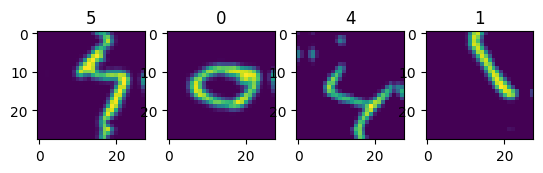

In [258]:
## the images with their label
fig, axs = plt.subplots(1,4)
for i in range(0,4):
    axs[i].imshow(train_images[i])
    axs[i].set_title(train_labels[i])
fig.savefig("../img/train_images.png")

In [259]:
# print(f'X:\n {X}')
# print(f'Y:\n {Y}')
print(f'Shape of data X:{X_train.shape}\n')
print(f'Shape of data Y:{Y_train.shape}\n')

Shape of data X:(60000, 28, 28, 1)

Shape of data Y:(60000,)



Les images ont comme dimensions 28x28 pixels, il y en a 60000.

<BarContainer object of 10 artists>

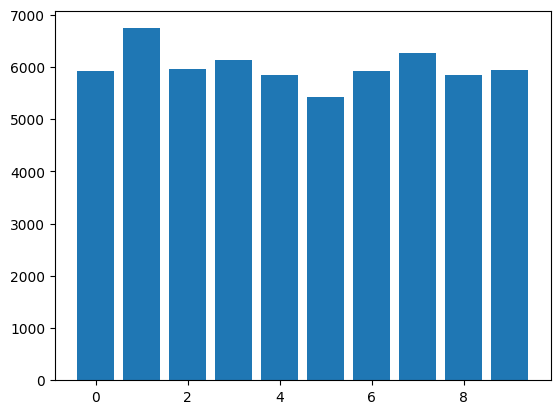

In [260]:
unique, counts = np.unique(Y_train, return_counts=True)
plt.bar(np.unique(Y_train), counts)

Les labels ne comportent que 10 valeurs, de 0 à 9, les chiffres contenus dans les images. 
On observe une bonne répartition, avec une entropie élevée ; l'accuracy est donc adéquate coimme métrique. 

## 3. Réaliser un premier apprentissage et une validation de la classification 

In [261]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Conv1D, Flatten, Conv2D, MaxPooling2D, MaxPooling1D
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.utils import plot_model

In [262]:
callback = EarlyStopping(monitor='val_accuracy',
                         patience=10,
                         restore_best_weights=True)

In [263]:
# On transforme les valeurs en vecteur de données one-hot
Y_train_oh = to_categorical(Y_train)
Y_test_oh = to_categorical(Y_test)
print(f'Y_train shape : {Y_train.shape} ; first value = {Y_train[0]}')
print(f'Y_train_oh shape : {Y_train_oh.shape} ; first value = {Y_train_oh[0]}')

Y_train shape : (60000,) ; first value = 5
Y_train_oh shape : (60000, 10) ; first value = [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [264]:
random.seed(666) ## pour être le plus reproductible possible
def make_dense1():
    model = Sequential() 
    ## On transforme la donnée 2D en donnée 1D
    model.add(Flatten(input_shape=(28,28,1)))
    ## Activation 'rectified linear unit'='relu' avec 256 neurones
    model.add(Dense(units=256, activation='relu', kernel_initializer='he_uniform'))
    ## Un dropout de 30% 
    model.add(Dropout(0.3))
    model.add(Dense(units=128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.3))
    ## 10 neurones output pour les 10 classes possibles, avec softwax pour que le total soit égal à 1
    model.add(Dense(units=10, activation='softmax'))
    ## optimiseur RMSprop
    opt = optimizers.RMSprop(learning_rate=0.001)
    model.compile(optimizer=opt, 
                  ## fonction de coût cross-entropie
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'], weighted_metrics=["accuracy"])

    return model

In [265]:
model_dense1 = make_dense1()

/bigdisk/nick/Moi/etude/M2/artificial/projet_cours_MNIST/.pixi/envs/default/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [266]:
plot_model(model_dense1, to_file="../img/model_dense1.png",
               show_shapes=True, show_layer_names=True)
print(f'{model_dense1.summary()}')

Model: "sequential_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_48 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_131 (Dense)               │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_84 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_132 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_85 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_133 (Dense)               │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

None


In [267]:
hist_dense1 = model_dense1.fit(X_train, 
                             Y_train_oh, 
                             validation_split=0.2, 
                             epochs=40, 
                             batch_size=100)
## save model
model_dense1.save('../results/model_dense.v1.keras')

Epoch 1/40
480/480 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2472 - loss: 2.0751 - weighted_accuracy: 0.2472 - val_accuracy: 0.5508 - val_loss: 1.3539 - val_weighted_accuracy: 0.5508
Epoch 2/40
480/480 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5133 - loss: 1.4359 - weighted_accuracy: 0.5133 - val_accuracy: 0.6647 - val_loss: 1.0673 - val_weighted_accuracy: 0.6647
Epoch 3/40
480/480 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5949 - loss: 1.2186 - weighted_accuracy: 0.5949 - val_accuracy: 0.7101 - val_loss: 0.9222 - val_weighted_accuracy: 0.7101
Epoch 4/40
480/480 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6358 - loss: 1.1035 - weighted_accuracy: 0.6358 - val_accuracy: 0.7318 - val_loss: 0.8468 - val_weighted_accuracy: 0.7318
Epoch 5/40
480/480 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6702 - loss: 1.0030 - weighted_accuracy: 0.6702 - val_accuracy: 0.7562 - val_loss: 0.7892 - val_weighted_accuracy: 0.7562
Epoch 6/40
480/480 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accura

dict_keys(['accuracy', 'loss', 'weighted_accuracy', 'val_accuracy', 'val_loss', 'val_weighted_accuracy'])


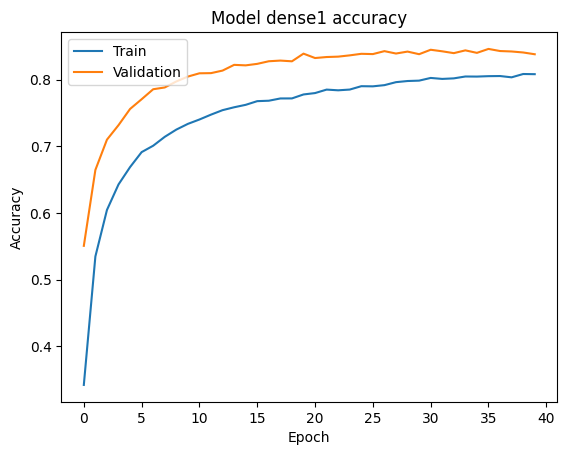

dict_keys(['accuracy', 'loss', 'weighted_accuracy', 'val_accuracy', 'val_loss', 'val_weighted_accuracy'])


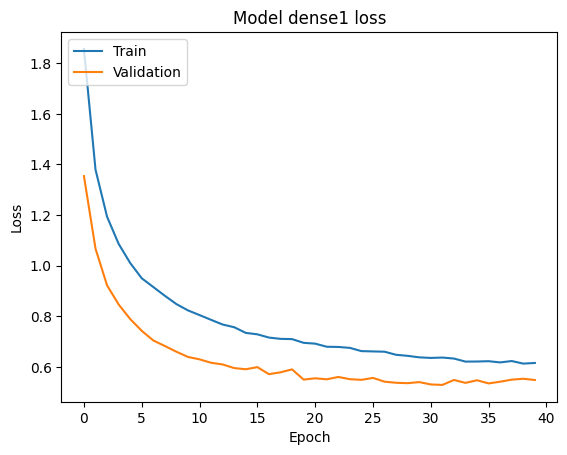

<Figure size 640x480 with 0 Axes>

In [268]:
## plot of accuracy
print(hist_dense1.history.keys())
plt.plot(hist_dense1.history['accuracy'])
plt.plot(hist_dense1.history['val_accuracy'])
plt.title('Model dense1 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.savefig('../img/model_dense1_accuracy')

## plot of loss
print(hist_dense1.history.keys())
plt.plot(hist_dense1.history['loss'])
plt.plot(hist_dense1.history['val_loss'])
plt.title('Model dense1 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.savefig('../img/model_dense1_loss')

On peut maintenant faire la cross-validation avec le jeu de données test.

In [269]:
## predict the number labels for the test image dataset
Y_pred_oh_dense1 = model_dense1.predict(X_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step


In [270]:
## transform back the predicted and test classes to classes
print(Y_pred_oh_dense1.shape)
print(Y_test_oh.shape)
Y_pred_classes_dense1 = np.argmax(Y_pred_oh_dense1,axis = 1)
Y_test_classes = np.argmax(Y_test_oh,axis = 1)
print(Y_pred_classes_dense1, Y_pred_classes_dense1.shape)
print(Y_test_classes, Y_test_classes.shape)


(10000, 10)
(10000, 10)
[7 2 1 ... 4 4 6] (10000,)
[7 2 1 ... 4 5 6] (10000,)


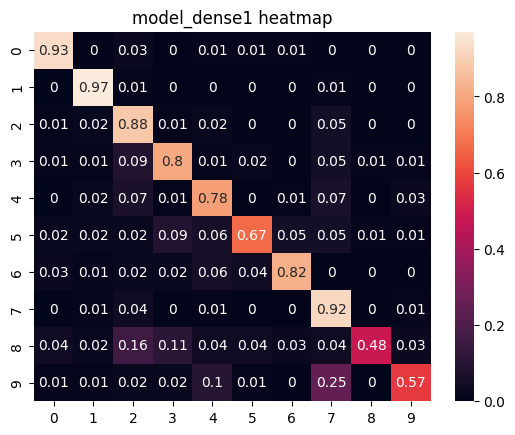

In [271]:
conf_matrix = confusion_matrix(Y_test_classes, Y_pred_classes_dense1, normalize='true')
conf_matrix = np.around(conf_matrix, 2)
heatmap = sns.heatmap(conf_matrix, annot=True)
heatmap.set_title('model_dense1 heatmap')
fig = heatmap.get_figure()
fig.savefig("../img/model_dense1_heatmap.png")

Maintenant pour le CNN :

In [272]:
random.seed(666)
def make_cnn1():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', 
                     kernel_initializer='he_uniform', input_shape=(28, 28,1)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', 
                     kernel_initializer='he_uniform'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Flatten())

    model.add(Dense(10, activation='softmax'))

    opt = optimizers.RMSprop(learning_rate=0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'], weighted_metrics=["accuracy"])

    return model

In [273]:
model_cnn1 = make_cnn1()

/bigdisk/nick/Moi/etude/M2/artificial/projet_cours_MNIST/.pixi/envs/default/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [274]:
plot_model(model_cnn1, to_file="../img/model_cnn1.png",
               show_shapes=True, show_layer_names=True)
print(f'{model_cnn1.summary()}')

Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_49 (Flatten)            │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_134 (Dense)               │ (None, 10)             │        16,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,826 (136.04 KB)

 Trainable params: 34,826 (136.04 KB)

 Non-trainable params: 0 (0.00 B)

None


In [275]:
hist_cnn1 = model_cnn1.fit(X_train, 
                            Y_train_oh, 
                            validation_split=0.2, 
                            epochs=20, 
                            batch_size=50)
model_cnn1.save('../results/model_cnn1.keras')

Epoch 1/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.4572 - loss: 1.5866 - weighted_accuracy: 0.4572 - val_accuracy: 0.7812 - val_loss: 0.7012 - val_weighted_accuracy: 0.7812
Epoch 2/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.7944 - loss: 0.6616 - weighted_accuracy: 0.7944 - val_accuracy: 0.8658 - val_loss: 0.4495 - val_weighted_accuracy: 0.8658
Epoch 3/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8649 - loss: 0.4442 - weighted_accuracy: 0.8649 - val_accuracy: 0.8652 - val_loss: 0.4428 - val_weighted_accuracy: 0.8652
Epoch 4/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8912 - loss: 0.3583 - weighted_accuracy: 0.8912 - val_accuracy: 0.8862 - val_loss: 0.3690 - val_weighted_accuracy: 0.8862
Epoch 5/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9080 - loss: 0.3080 - weighted_accuracy: 0.9080 - val_accuracy: 0.8908 - val_loss: 0.3532 - val_weighted_accuracy: 0.8908
Epoch 6/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accura

dict_keys(['accuracy', 'loss', 'weighted_accuracy', 'val_accuracy', 'val_loss', 'val_weighted_accuracy'])


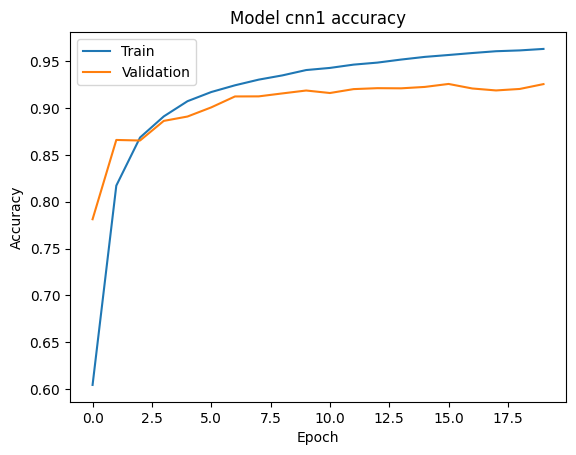

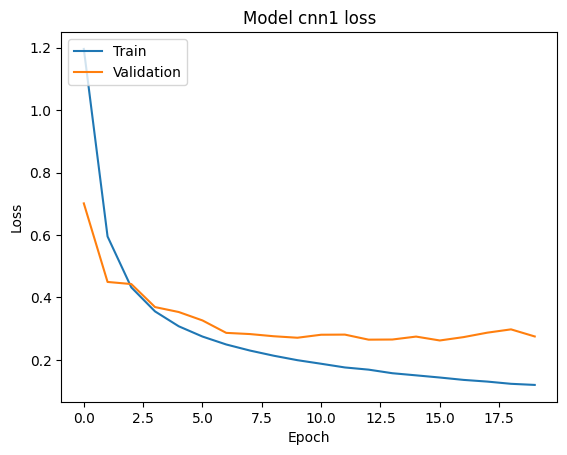

<Figure size 640x480 with 0 Axes>

In [276]:
print(hist_cnn1.history.keys())
plt.plot(hist_cnn1.history['accuracy'])
plt.plot(hist_cnn1.history['val_accuracy'])
plt.title('Model cnn1 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.savefig('../img/model_cnn1_accuracy')

plt.plot(hist_cnn1.history['loss'])
plt.plot(hist_cnn1.history['val_loss'])
plt.title('Model cnn1 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.savefig('../img/model_cnn1_loss')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(10000, 10)
(10000, 10)
[4 2 1 ... 4 5 6] 10000
[7 2 1 ... 4 5 6] 10000


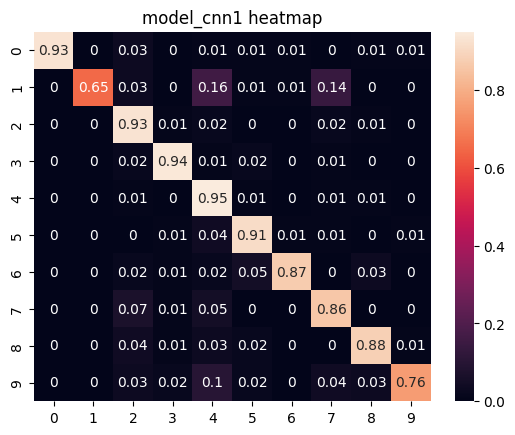

In [277]:
Y_pred_oh_cnn1 = model_cnn1.predict(X_test)
print(Y_pred_oh_cnn1.shape)
print(Y_test_oh.shape)
Y_pred_classes_cnn1 = np.argmax(Y_pred_oh_cnn1,axis = 1)
Y_test_classes = np.argmax(Y_test_oh,axis = 1)
print(Y_pred_classes_cnn1, len(Y_pred_classes_cnn1))
print(Y_test_classes, len(Y_test_classes))

conf_matrix = confusion_matrix(Y_test_classes, Y_pred_classes_cnn1, normalize='true')
conf_matrix = np.around(conf_matrix, 2)
heatmap = sns.heatmap(conf_matrix, annot=True)
heatmap.set_title('model_cnn1 heatmap')
fig = heatmap.get_figure()
fig.savefig("../img/model_cnn1_heatmap.png")


## 5. Comparer la classification en faisant varier quelques paramètres

 Il n'est pas intéressant d'ajouter plus de 3 couches denses ; cela ne rendra pas le modèle tellement plus précis et il convergera moins bien. On peut donc en ajouter une, avec un fort bottlenecking, mais pas de dropout juste avant le softmax.

/bigdisk/nick/Moi/etude/M2/artificial/projet_cours_MNIST/.pixi/envs/default/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/40
480/480 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2219 - loss: 2.1263 - weighted_accuracy: 0.2219 - val_accuracy: 0.5056 - val_loss: 1.4482 - val_weighted_accuracy: 0.5056
Epoch 2/40
480/480 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4770 - loss: 1.5192 - weighted_accuracy: 0.4770 - val_accuracy: 0.6457 - val_loss: 1.1251 - val_weighted_accuracy: 0.6457
Epoch 3/40
480/480 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5685 - loss: 1.2767 - weighted_accuracy: 0.5685 - val_accuracy: 0.6787 - val_loss: 0.9746 - val_weighted_accuracy: 0.6787
Epoch 4/40
480/480 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6188 - loss: 1.1382 - weighted_accuracy: 0.6188 - val_accuracy: 0.7232 - val_loss: 0.8778 - val_weighted_accuracy: 0.7232
Epoch 5/40
480/480 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6481 - loss: 1.0536 - weighted_accuracy: 0.6481 - val_accuracy: 0.7426 - val_loss: 0.8141 - val_weighted_accuracy: 0.7426
Epoch 6/40
480/480 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accura

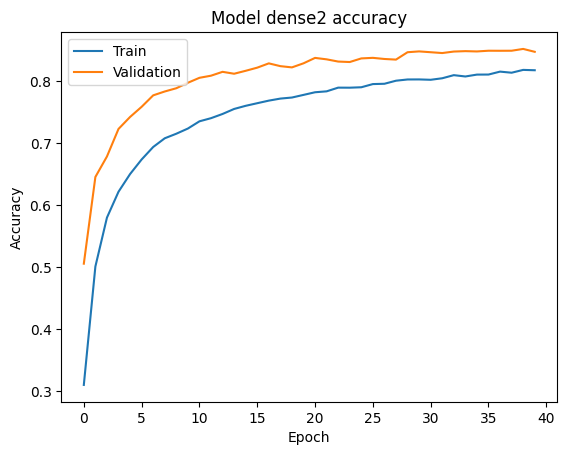

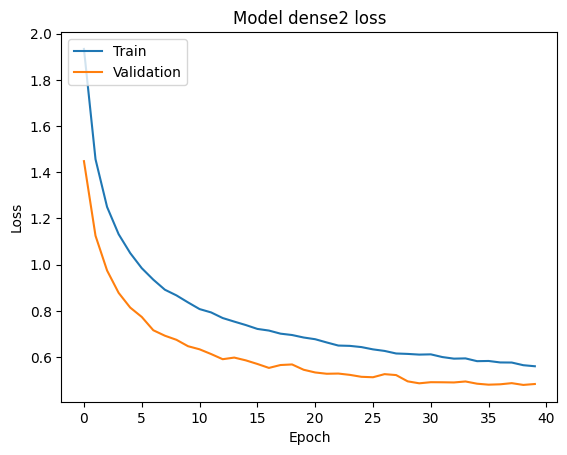

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


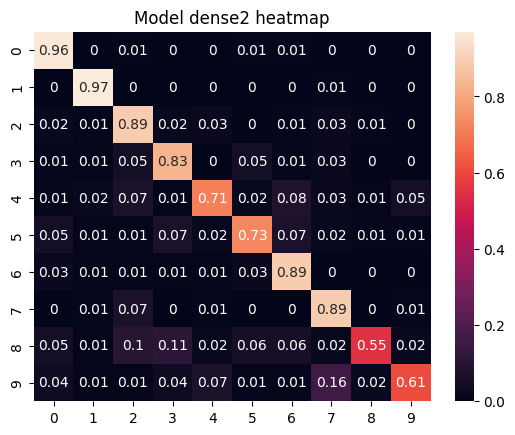

In [278]:
random.seed(666)
def make_dense2():
    model = Sequential() 
    ## On transforme la donnée 2D en donnée 1D
    model.add(Flatten(input_shape=(28,28,1)))
    ## Activation 'rectified linear unit'='relu' avec 256 neurones
    model.add(Dense(units=256, activation='relu', kernel_initializer='he_uniform'))
    ## Un dropout de 30% 
    model.add(Dropout(0.3))
    model.add(Dense(units=128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.3))
    model.add(Dense(units=32, activation='relu', kernel_initializer='he_uniform'))

    ## 10 neurones output pour les 10 classes possibles, avec softwax pour que le total soit égal à 1
    model.add(Dense(units=10, activation='softmax'))
    ## optimiseur RMSprop
    opt = optimizers.RMSprop(learning_rate=0.001)
    model.compile(optimizer=opt, 
                  ## fonction de coût cross-entropie
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'], weighted_metrics=["accuracy"])
    return model

model_dense2 = make_dense2()
plot_model(model_dense2, to_file="../img/model_dense2.png",
               show_shapes=True, show_layer_names=True)
# print(f'{model_dense1.summary()}')
hist_dense2 = model_dense2.fit(X_train, Y_train_oh, 
                                  validation_split=0.2, 
                                  epochs=40, 
                                  batch_size=100)
model_dense2.save('../results/model_dense2.keras')
print(hist_dense2.history.keys())
plt.plot(hist_dense2.history['accuracy'])
plt.plot(hist_dense2.history['val_accuracy'])
plt.title('Model dense2 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.savefig("../img/model_dense2_accuracy.png")

plt.plot(hist_dense2.history['loss'])
plt.plot(hist_dense2.history['val_loss'])
plt.title('Model dense2 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.savefig("../img/model_dense2_loss.png")

Y_pred_oh_dense2 = model_dense2.predict(X_test)
# print(Y_pred_oh.shape)
# print(Y_test_oh.shape)
Y_pred_classes_dense2 = np.argmax(Y_pred_oh_dense2,axis = 1)
# Y_test_classes = np.argmax(Y_test_oh,axis = 1)
# print(Y_pred_classes, len(Y_pred_classes))
# print(Y_test_classes, len(Y_test_classes))
conf_matrix = confusion_matrix(Y_test_classes, Y_pred_classes_dense2, normalize='true')
conf_matrix = np.around(conf_matrix, 2)
heatmap = sns.heatmap(conf_matrix, annot=True)
heatmap.set_title('Model dense2 heatmap')
fig = heatmap.get_figure()
fig.savefig("../img/model_dense2_heatmap.png")

Pour le modèle en convolution, on peut ajouter une couche de neurones dense, avec 128 neurones. Cependant, il est important d'ajouter après un dropout afin d'éviter du surapprentissage. 

/bigdisk/nick/Moi/etude/M2/artificial/projet_cours_MNIST/.pixi/envs/default/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 18s 33ms/step - accuracy: 0.3640 - loss: 1.8174 - val_accuracy: 0.7711 - val_loss: 0.8017
Epoch 2/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.7245 - loss: 0.8640 - val_accuracy: 0.8602 - val_loss: 0.4893
Epoch 3/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.8092 - loss: 0.6042 - val_accuracy: 0.8917 - val_loss: 0.3716
Epoch 4/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.8510 - loss: 0.4735 - val_accuracy: 0.9090 - val_loss: 0.3081
Epoch 5/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.8765 - loss: 0.3971 - val_accuracy: 0.9180 - val_loss: 0.2800
Epoch 6/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.8947 - loss: 0.3430 - val_accuracy: 0.9264 - val_loss: 0.2432
Epoch 7/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.9061 - loss: 0.2997 - val_accuracy: 0.9317 - val_loss: 0.2313
Epoch 8/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - accuracy: 0.9159 - loss: 0.2699 - va

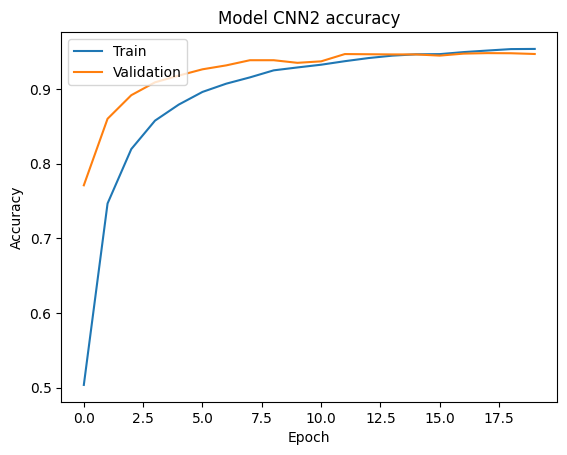

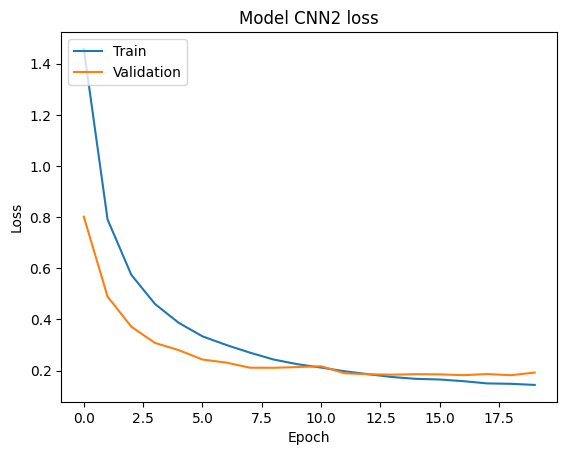

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


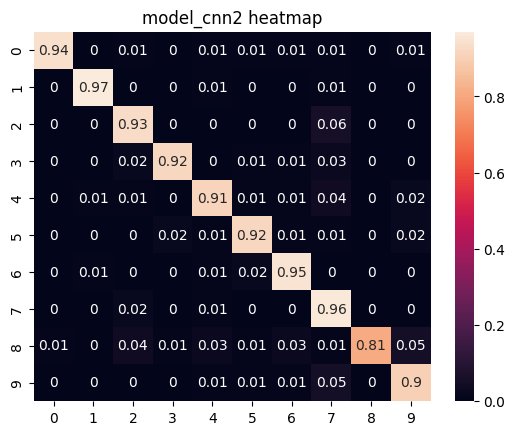

In [279]:
random.seed(666)
def make_cnn2():
    model = Sequential() 
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28,1)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    ## Add a dense layer
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(0.3))
    # 10 output neuron for the 10 possibles labels, the 10 classes
    model.add(Dense(units=10, activation='softmax'))
    opt = optimizers.RMSprop(learning_rate=0.0005)
    model.compile(optimizer=opt, loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

model_cnn2 = make_cnn2()
plot_model(model_cnn2, to_file="../img/model_cnn2.png",
               show_shapes=True, show_layer_names=True)
# print(f'{model_dense1.summary()}')
hist_cnn2 = model_cnn2.fit(X_train, 
                              Y_train_oh, 
                              validation_split=0.2, 
                              epochs=20, 
                              batch_size=100)
model_cnn2.save('../results/model_cnn2.keras')
print(hist_cnn2.history.keys())
plt.plot(hist_cnn2.history['accuracy'])
plt.plot(hist_cnn2.history['val_accuracy'])
plt.title('Model CNN2 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.savefig('../img/model_cnn2_accuracy')

plt.plot(hist_cnn2.history['loss'])
plt.plot(hist_cnn2.history['val_loss'])
plt.title('Model CNN2 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.savefig('../img/model_cnn2_loss')

Y_pred_oh_cnn2 = model_cnn2.predict(X_test)
# print(Y_pred_oh.shape)
# print(Y_test_oh.shape)
Y_pred_classes_cnn2 = np.argmax(Y_pred_oh_cnn2,axis = 1)
# Y_test_classes = np.argmax(Y_test_oh,axis = 1)
# print(Y_pred_classes, len(Y_pred_classes))
# print(Y_test_classes, len(Y_test_classes))
conf_matrix = confusion_matrix(Y_test_classes, Y_pred_classes_cnn2, normalize='true')
conf_matrix = np.around(conf_matrix, 2)
heatmap = sns.heatmap(conf_matrix, annot=True)
heatmap.set_title('model_cnn2 heatmap')
fig = heatmap.get_figure()
fig.savefig("../img/model_cnn2_heatmap.png")

## 6. Comparer les résultats des deux approches

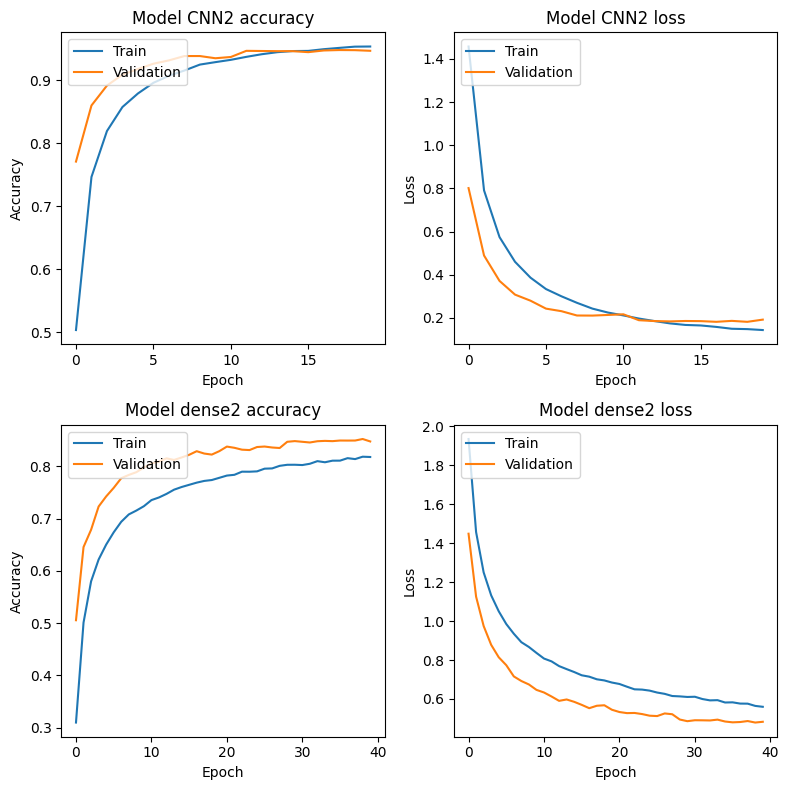

In [280]:
fig, axes = plt.subplots(nrows=2, ncols=2)

axes[0][0].plot(hist_cnn2.history['accuracy'])
axes[0][0].plot(hist_cnn2.history['val_accuracy'])
axes[0][0].set_title('Model CNN2 accuracy')
axes[0][0].set_ylabel('Accuracy')
axes[0][0].set_xlabel('Epoch')
axes[0][0].legend(['Train', 'Validation'], loc='upper left')

axes[0][1].plot(hist_cnn2.history['loss'])
axes[0][1].plot(hist_cnn2.history['val_loss'])
axes[0][1].set_title('Model CNN2 loss')
axes[0][1].set_ylabel('Loss')
axes[0][1].set_xlabel('Epoch')
axes[0][1].legend(['Train', 'Validation'], loc='upper left')

axes[1][0].plot(hist_dense2.history['accuracy'])
axes[1][0].plot(hist_dense2.history['val_accuracy'])
axes[1][0].set_title('Model dense2 accuracy')
axes[1][0].set_ylabel('Accuracy')
axes[1][0].set_xlabel('Epoch')
axes[1][0].legend(['Train', 'Validation'], loc='upper left')

axes[1][1].plot(hist_dense2.history['loss'])
axes[1][1].plot(hist_dense2.history['val_loss'])
axes[1][1].set_title('Model dense2 loss')
axes[1][1].set_ylabel('Loss')
axes[1][1].set_xlabel('Epoch')
axes[1][1].legend(['Train', 'Validation'], loc='upper left')

fig.set_figheight(8)
fig.set_figwidth(8)
fig.tight_layout()
fig.savefig('../img/models_cnn2_dense2')

Le CNN a une meilleure accurary (0.9366) que le dense (0.7298) et a une function de perte plus basse (0.2272 contre 0.8590).

Text(0.5, 1.0, 'model_cnn2 heatmap')

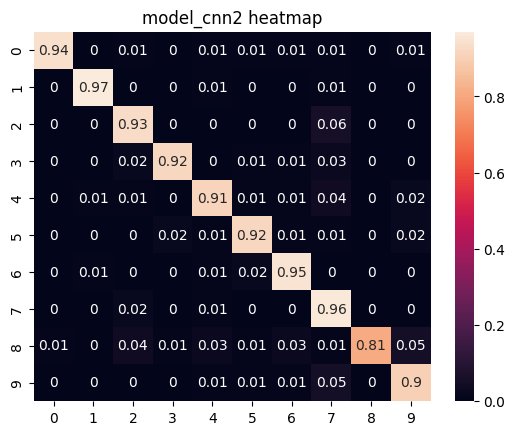

In [281]:
conf_matrix = confusion_matrix(Y_test_classes, Y_pred_classes_cnn2, normalize='true')
conf_matrix = np.around(conf_matrix, 2)
heatmap = sns.heatmap(conf_matrix, annot=True)
heatmap.set_title('model_cnn2 heatmap')


Text(0.5, 1.0, 'model_dense2 heatmap')

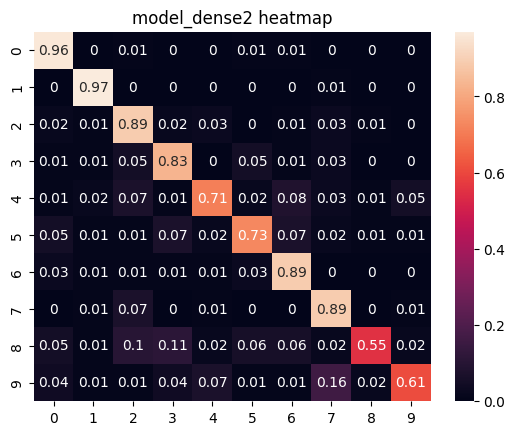

In [282]:

conf_matrix = confusion_matrix(Y_test_classes, Y_pred_classes_dense2, normalize='true')
conf_matrix = np.around(conf_matrix, 2)
heatmap = sns.heatmap(conf_matrix, annot=True)
heatmap.set_title('model_dense2 heatmap')

L'usage de couches de convolution 2D rend le modèle beaucoup plus fiable. 

Le CNN a des meilleurs résultats sur le jeu de données test. 

En effet, la convolution 2D permet d'identifier les caractéristiques des images, et le maxpooling permet de sélectionner les caractéristiques intéressantes. Des couches denses peuvent ensuite beaucoup plus facilement identifier des motifs et apprendre à reconnaître les chiffres.  

Le CNN est donc bien meilleur pour ce type de tâche de reconnaissance d'images.